In [115]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Activation, Dropout, Reshape

# Load MNIST dataset from Keras

In [123]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

x_train.shape (60000, 28, 28)
x_test.shape (10000, 28, 28)
y_train.shape (60000,)
y_test.shape (10000,)


In [23]:
x_train = x_train[:2000]
y_train = y_train[:2000]
x_test = x_test[:100]
y_test = y_test[:100]

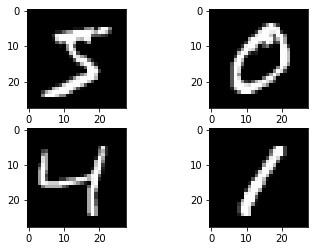

In [24]:
# Display several images
plt.subplot(221)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))
plt.show()

# Create train/test sets

In [124]:
# Reshape input image data to rows of 784 grayscale values normalized between 0 and 1
X_train = x_train.reshape(x_train.shape[0], 28*28)
X_test = x_test.reshape(x_test.shape[0], 28*28)

# One hot encode classes
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)
num_classes = Y_test.shape[1]

print('Example label:', Y_train[0])
print('# Classes:', num_classes)
print('X_train.shape:', X_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_train.shape:', Y_train.shape)
print('Y_test.shape:', Y_test.shape)

Example label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
# Classes: 10
X_train.shape: (60000, 784)
X_test.shape: (10000, 784)
Y_train.shape: (60000, 10)
Y_test.shape: (10000, 10)


# Part 1: MNIST Classifier using Numpy

## Build neural network

In [292]:
# Mean Squared Error
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient

class Layer:
  def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
    self.num_input_nodes = num_input_nodes
    self.num_output_nodes = num_output_nodes
    # Init layer with random weights and bias
    self.weights = 0.2 * np.random.random((num_input_nodes, num_output_nodes)) - 0.1
    self.bias = 0.2 * np.random.rand((1)) - 0.1
    self.X = np.zeros([num_input_nodes])
    # Set activation function
    if activation == 'relu':
      self.activation = Relu()
    else: 
      self.activation = None
  
  def forward(self, X, dropout):
    self.X = X.copy()

    self.Z = X @ self.weights + self.bias
    # Pass output to activation function
    if self.activation == None:
      return self.Z 
    else:
      # Perform dropout and inverted dropout to rescale weights
      weights_dropout = np.random.binomial(1, dropout, size=self.Z.shape) / dropout
      return self.activation.forward(self.Z) * weights_dropout

  # Predict without storing values
  def predict(self, X):
    if self.activation == None:
      return X @ self.weights + self.bias 
    else:
      return self.activation.predict(X @ self.weights + self.bias)

  # Perform backpropogation using chain rule
  def backward(self, upstream_gradient):
    curr_upstream_gradient = upstream_gradient.copy()
    # Perform backpropagation on activation function first before backpropagation on weight and bias gradient
    if self.activation != None:
      curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)
    
    # Compute the gradient of the weights wrt to loss by taking dot product of upstream gradient with local gradient
    self.dJdW = self.X.T @ curr_upstream_gradient
    # Bias is a constant so its derivative is 1 and the dot product of 1 and the upstream gradient is the sum of the gradient
    self.dJdb = curr_upstream_gradient.sum()
    # Compute the gradient of input X wrt to loss by taking dot product of upstream gradient with local gradient. 
    # This value is returned because it serves as the new "upstream" gradient in the previous layer
    self.dJdX = curr_upstream_gradient @ self.weights.T
    return self.dJdX

  # Update weight and bias params with learning rate step size
  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}'.format(self.num_input_nodes, self.num_output_nodes, self.activation)

class Relu:
  def __init__(self):
    self.input = np.array([])

  def forward(self, input):
    self.input = input.copy()
    self.output = np.clip(self.input, 0, None)
    return self.output
  
  # Predict without storing values
  def predict(self, input):
    return np.clip(input, 0, None)
  
  # If input is less than 0, derivative is 0. If input is greater than 0, derivative is 1
  def backward(self, upstream_gradient):
    return (self.input > 0) * upstream_gradient
  
  # No update needed to ReLU members
  def update(self, lr):
    return

  def __str__(self):
    return 'ReLu'

class NeuralNet:
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation))

    # Print network architecture for debugging
    print('Neural Net Architecture:')
    for i, layer in enumerate(self.layers):
      print('=== Layer {} ==='.format(i))
      print(layer)
    print()

  def forward(self, inputs, dropout):
    curr_out = inputs.copy()
    for l in self.layers:
      curr_out = l.forward(curr_out, dropout)
    return curr_out
  
  # Predict without storing values
  def predict(self, inputs):
    curr_out = inputs.copy()
    for l in self.layers:
      curr_out = l.predict(curr_out)
    return curr_out
  
  def backward(self, y_pred, y_true):
    # Start with gradient from loss function wrt prediction
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    loss_gradient = mse.backward()

    # Pass dJ/dy to last layer of network and compute gradients at each layer backwards
    gradient = loss_gradient.copy()
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  # Training loop over # of epochs
  def fit(self, datagen, X_train_augmented, X_train, y_train, X_test, y_test, epochs, batch_size, dropout):
    train_errors = []
    train_accuracies = [] 
    test_errors = [] 
    test_accuracies = []
    for e in range(epochs):
      # Use SGD with batch size from ImageDataGenerator
      batches = 0
      for X_batch, y in datagen.flow(X_train_augmented, y_train, batch_size=batch_size):
        # Train
        X = X_batch.reshape(X_batch.shape[0], 28*28) / 255.
        y_pred = self.forward(X, dropout)
        self.backward(y_pred, y)
        self.update(lr)

        if batches >= len(X_train_augmented) / batch_size:
          break
        batches += 1

      # Get training performance metrics
      y_pred = self.predict(X_train)
      train_error = mean_squared_error(y_train, y_pred)
      train_errors.append(train_error)
      train_accuracy = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
      train_accuracies.append(train_accuracy)

      # Get validation performance metrics
      y_pred = self.predict(X_test)
      test_error = mean_squared_error(y_test, y_pred)
      test_errors.append(test_error)
      test_accuracy = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
      test_accuracies.append(test_accuracy)
      print('Epoch: {} Training Error: {} Training Accuracy: {} Validation Error: {} Validation Accuracy: {} '.format(e, round(train_error, 3), round(train_accuracy, 3), round(test_error, 3), round(test_accuracy, 3)))

    return train_errors, train_accuracies, test_errors, test_accuracies

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

## Define hyperparameters

In [307]:
epochs = 300
lr = 0.005
batch_size = 128
num_hidden_layers = [128, 64]
dropout = 0.9 # rate which nodes retained

n_inputs = X_train.shape[1]
n_outputs = Y_train.shape[1]
print(n_inputs, n_outputs)

784 10


## Perform image augmentations

In [308]:
datagen = ImageDataGenerator(
  rotation_range=5
)

augmented_x_train = x_train.reshape(-1,28,28,1)

## Train model with SGD

In [309]:
# Create NeuralNet from implemented interface and train on MNIST dataset
nn = NeuralNet(num_inputs=n_inputs, num_hidden=num_hidden_layers, num_outputs=n_outputs, activation='relu')
train_errors, train_accuracies, test_errors, test_accuracies = nn.fit(datagen, augmented_x_train, X_train, Y_train, X_test, Y_test, epochs, batch_size, dropout)

Neural Net Architecture:
=== Layer 0 ===
Layer: (784,128) Activation Function: ReLu
=== Layer 1 ===
Layer: (128,64) Activation Function: ReLu
=== Layer 2 ===
Layer: (64,10) Activation Function: None

Epoch: 0 Training Error: 0.09 Training Accuracy: 0.184 Validation Error: 0.09 Validation Accuracy: 0.19 
Epoch: 1 Training Error: 0.088 Training Accuracy: 0.214 Validation Error: 0.088 Validation Accuracy: 0.22 
Epoch: 2 Training Error: 0.086 Training Accuracy: 0.247 Validation Error: 0.087 Validation Accuracy: 0.25 
Epoch: 3 Training Error: 0.085 Training Accuracy: 0.288 Validation Error: 0.086 Validation Accuracy: 0.27 
Epoch: 4 Training Error: 0.084 Training Accuracy: 0.32 Validation Error: 0.084 Validation Accuracy: 0.3 
Epoch: 5 Training Error: 0.083 Training Accuracy: 0.359 Validation Error: 0.083 Validation Accuracy: 0.33 
Epoch: 6 Training Error: 0.082 Training Accuracy: 0.403 Validation Error: 0.082 Validation Accuracy: 0.38 
Epoch: 7 Training Error: 0.08 Training Accuracy: 0.436 

## Plot training/validation accuracy and loss over epochs

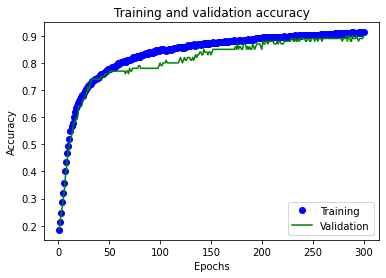

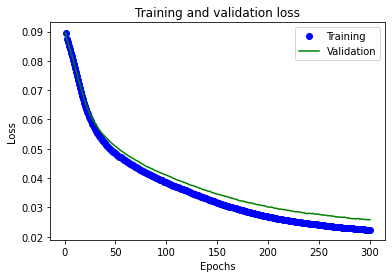

In [310]:
epochs_list = range(1, epochs + 1)

# Plot train vs validation accuracy
plt.plot(epochs_list, train_accuracies, 'bo', label='Training')
plt.plot(epochs_list, test_accuracies, 'g', label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot train vs validation loss
plt.figure()
plt.plot(epochs_list, train_errors, 'bo', label='Training')
plt.plot(epochs_list, test_errors, 'g', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Show confusion matrix

In [135]:
def plot_confusion_matrix(cm, classes,
                          title='MNIST Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

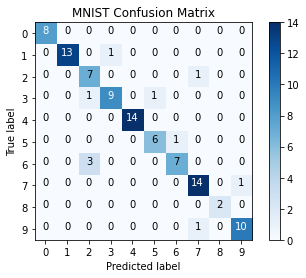

In [352]:
# Generate predictions and fetch confusion matrix to plot
y_pred = nn.predict(X_test)
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm, list(range(0, 10)))

# Part 2: MNIST Classifier using Keras

## Define hyperparameters

In [137]:
epochs = 100
lr = 0.01
batch_size = 128

input_dim = X_train.shape[1]
num_classes = Y_train.shape[1]
print(input_dim)
print(num_classes)

784
10


## Perform image augmentations

In [138]:
# Reshape image vectors
augmented_x_train = x_train.reshape(-1, 28, 28, 1)
augmented_x_test = x_test.reshape(-1, 28, 28, 1)

# Create image data generator to load images in batches
data_gen = ImageDataGenerator()
data_gen.fit(augmented_x_train)
train_batches = data_gen.flow(augmented_x_train, Y_train, batch_size=batch_size)
val_batches = data_gen.flow(augmented_x_test, Y_test, batch_size=batch_size)

## Train model with SGD

In [142]:
model = Sequential()
# Reshape image to correct format from ImageDataGenerator
model.add(Reshape((-1,), input_shape = (28, 28, 1)))
model.add(Dense(28 * 28, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))
# Output softmax of 10 possible classes for prediction
model.add(Dense(10, activation='softmax'))

# Set SGD as optimizer, categorical_crossentropy for loss, and accuracy and output metric 
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

# Train model using ImageDataGenerator along with validation step
history = model.fit(
  train_batches, 
  steps_per_epoch=augmented_x_train.shape[0] // batch_size,
  epochs=epochs, 
  validation_data=val_batches, 
  validation_steps=augmented_x_test.shape[0] // batch_size
)

Epoch 1/100
468/468 [==============================] - 11s 22ms/step - loss: 2.0311 - accuracy: 0.2809 - val_loss: 0.6796 - val_accuracy: 0.8364
Epoch 2/100
468/468 [==============================] - 10s 22ms/step - loss: 0.9354 - accuracy: 0.6878 - val_loss: 0.4219 - val_accuracy: 0.8839
Epoch 3/100
468/468 [==============================] - 10s 21ms/step - loss: 0.6625 - accuracy: 0.7893 - val_loss: 0.3397 - val_accuracy: 0.9042
Epoch 4/100
468/468 [==============================] - 10s 22ms/step - loss: 0.5437 - accuracy: 0.8295 - val_loss: 0.2996 - val_accuracy: 0.9134
Epoch 5/100
468/468 [==============================] - 11s 22ms/step - loss: 0.4860 - accuracy: 0.8538 - val_loss: 0.2699 - val_accuracy: 0.9208
Epoch 6/100
468/468 [==============================] - 11s 23ms/step - loss: 0.4281 - accuracy: 0.8754 - val_loss: 0.2482 - val_accuracy: 0.9265
Epoch 7/100
468/468 [==============================] - 11s 22ms/step - loss: 0.3898 - accuracy: 0.8841 - val_loss: 0.2306 - val_ac

## Plot training/validation accuracy and loss over epochs

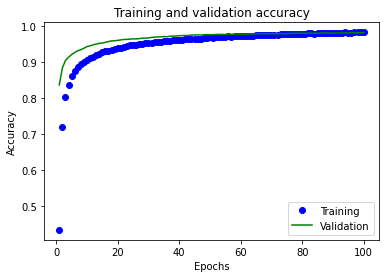

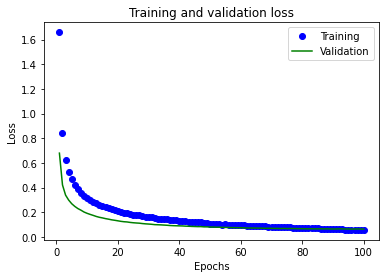

In [143]:
epochs_list = range(1, epochs + 1)

# Plot train vs validation accuracy
plt.plot(epochs_list, history.history['accuracy'], 'bo', label='Training')
plt.plot(epochs_list, history.history['val_accuracy'], 'g', label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot train vs validation loss
plt.figure()
plt.plot(epochs_list, history.history['loss'], 'bo', label='Training')
plt.plot(epochs_list, history.history['val_loss'], 'g', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Show confusion matrix

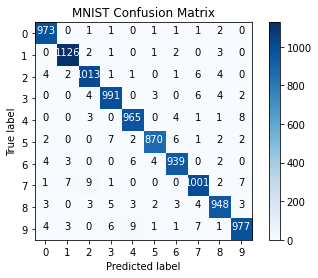

In [141]:
# Generate predictions and fetch confusion matrix to plot
y_pred = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(np.argmax(Y_test, axis=1), y_pred)
plot_confusion_matrix(cm, list(range(0, 10)))